# Quickstart

If you don't have opencv installed in your environment, run the following cell

In [ ]:
!pip install opencv-python

Let's start by download an image that we will use in this notebook

In [4]:
!wget -O test_img.jpg https://live.staticflickr.com/4418/36535618500_461f091dcd_z.jpg  >/dev/null 2>&1

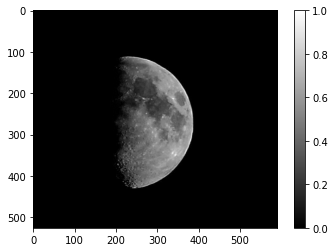

In [7]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread("test_img.jpg")[...,0].astype(float)/255.
plt.imshow(img, cmap="gray")
plt.colorbar()
plt.show()

# Heat equation

As an example, we will simulate the heat equation. 

$$
\frac{\partial}{\partial t}u = \nabla^2 u
$$

**NOTE** We don't enforce specific boundary conditions here: they are not yet implemented; currently, boundary conditions are implicitly defined by padding for convolutive operators in Finite Differences (which are padded with zeros), and periodic BC for Fourier discretizations. 
This is not suitable for proper integration of the heat equation, but works whenever we use some absorbing layer at the boundary: that is the majority of situations for acoustics. Clearly, a more suitable handling of generic boundary conditions would be a great addition to the package.

<br/>

We first define the domain where fields are defined. Then, the discretization family that will represent the inputs to the operator, in this case we use Finite Differences

In [8]:
from jaxdf.geometry import Domain

# Setting domain
domain = Domain(N=img.shape, dx=(1., 1.))

In [10]:
from jax import numpy as jnp
import numpy as np
from jaxdf.discretization import FiniteDifferences, OnGrid

# Define fields
params = jnp.expand_dims(jnp.asarray(img, dtype=np.float32),-1)
u = FiniteDifferences.from_grid(params, domain)

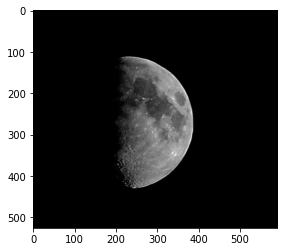

In [14]:
plt.imshow(u.on_grid, cmap="gray")

In [15]:
from jaxdf.operators.differential import laplacian
from jax import jit

@jit
def heat_rhs(u):
    return laplacian(u)

z = heat_rhs(u)

NameError: name '_convolve_kernel' is not defined

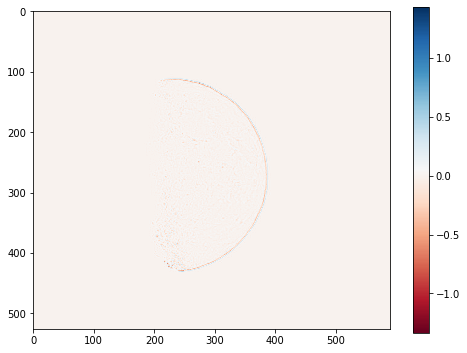

In [7]:
plt.figure(figsize=(8,6))
plt.imshow(z.get_field_on_grid(), cmap='RdBu'); plt.colorbar()

## Change discretization

Suppose we now want to use a Fourier Series discretization, rather than Finite Differences. To reuse the previously defined operator, we need to:

1. Define a new field with the new discretization
2. Call the operator
3. Extract the parameters and numerical function

In [8]:
from jaxdf.discretization import FourierSeries

u_f = FourierSeries.from_grid(params, domain)
z_f = heat_rhs(u_f)

Text(0.5, 1.0, 'Laplacian using Fourier')

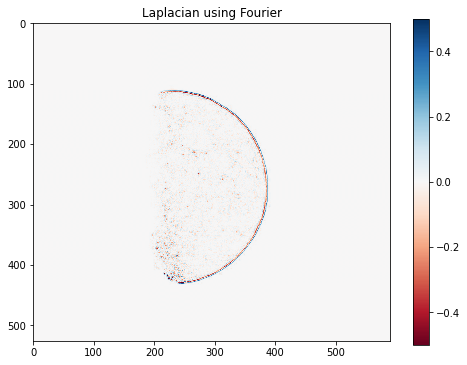

In [9]:
plt.figure(figsize=(8,6))
plt.imshow(z_f.get_field_on_grid(), cmap='RdBu', vmin=-0.5, vmax=0.5); plt.colorbar()
plt.title("Laplacian using Fourier")

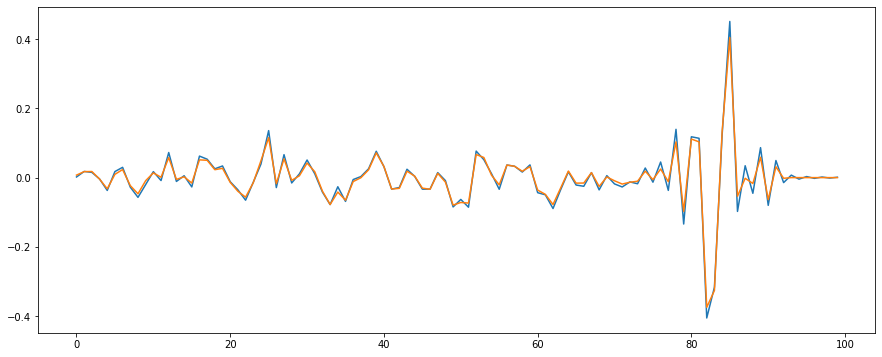

In [10]:
plt.figure(figsize=(15,6))
plt.plot(z_f.get_field_on_grid()[300,300:400])
plt.plot(z.get_field_on_grid()[300,300:400])

## Operator parameters

Each operator has the reserved imput keyword `params`, which can be used to directly pass the parameters to the operator.

The parameters depend on the discretization of the operator. To get the parameters of for a discretized field `u`, we just need to apply the opeartor to the field `u` and get the property `_op_params`

In [41]:
op_params = laplacian(u)._op_params
op_params_fourier = laplacian(u_f)._op_params

print(f"Laplacian parameters for FiniteDifferences: {op_params.keys()}")
print(f"Laplacian parameters for FourierSeries: {op_params_fourier.keys()}")

Laplacian parameters for FiniteDifferences: dict_keys(['laplacian_kernel'])
Laplacian parameters for FourierSeries: dict_keys(['k_vec'])


Text(0.5, 1.0, 'FiniteDifferences stencil for the Laplacian')

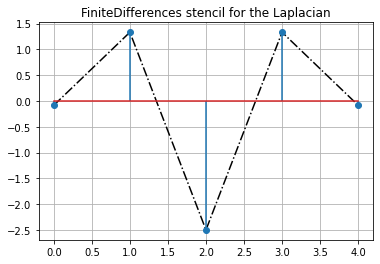

In [47]:
plt.plot(laplacian_kernel, '-.', color='k')
plt.stem(laplacian_kernel)
plt.grid()
plt.title("FiniteDifferences stencil for the Laplacian")

The parameters are pytrees, and can be used as inputs to a jittable function

In [55]:
@jit
def heat_rhs(u, op_params):
    q = laplacian(u, params=op_params)
    return jnp.mean(jnp.abs(q.get_field_on_grid()))

heat_rhs(u, op_params)

DeviceArray(0.00970099, dtype=float32)

Gradients can be taken with respect to the operator parameters too

In [57]:
from jax import grad

op_params_grad = grad(heat_rhs, argnums=(1,))(u, op_params)
print(f'Grads:\n\n{op_params_grad}')

Grads:

({'laplacian_kernel': DeviceArray([ 0.00094564, -0.00261824, -0.00687269, -0.0029075 ,
              0.00041137], dtype=float32)},)


## Euler integration

Let's now integrate the heat equation, using a simple euler integrator. 

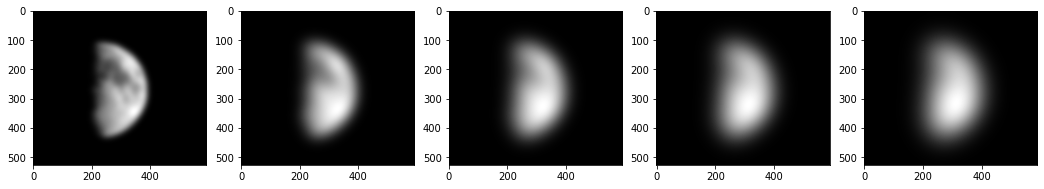

In [60]:
from jaxdf.ode import euler_integration

# Wrap function for integrator
@jit
def f(u, t):
    return laplacian(u)

dt = 0.1
output_steps = jnp.arange(0,10001,500)
    
# Integrate
snapshots = euler_integration(f, u_f, dt, output_steps)

# Plot
fig, axes = plt.subplots(1, 5, figsize=(18,4))
for i in range(len(axes)):
    axes[i].imshow(snapshots[i*4].get_field_on_grid(), cmap="gray")

Let's wrap it all up into a constructor. This funcion accepts a discretization, such that by changing the input we can construct different numerical simulators of the same equation

In [61]:
def make_simulator(
    discretization
):
    # Simulation parameters
    dt = 0.1
    output_steps = jnp.arange(0,10001,500)

    # Initialize field
    u0 = discretization.from_grid(params, domain)
        
    @jit
    def simulate(u0):
        return euler_integration(f, u0, dt, output_steps)
    
    return u0, simulate

In [62]:
u0, simulate = make_simulator(FourierSeries)

In [63]:
snapshots = simulate(u0)

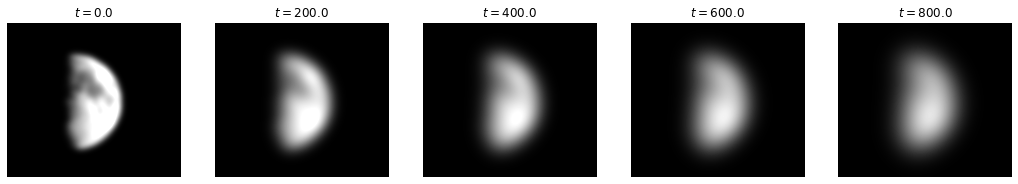

In [64]:
fig, axes = plt.subplots(1, 5, figsize=(18,4))
for i in range(len(axes)):
    axes[i].imshow(snapshots[i*4].get_field_on_grid(), vmin=0, vmax=.5, cmap="gray")
    axes[i].axis('off')
    axes[i].set_title(f"$t={str(output_steps[4*i]*dt)}$")
    
plt.savefig("diffusion_example.png")

In [65]:
u0, simulate = make_simulator(FiniteDifferences)
snapshots = simulate(u0)

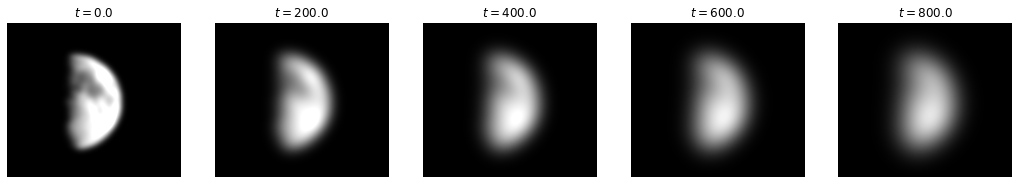

In [66]:
fig, axes = plt.subplots(1, 5, figsize=(18,4))
for i in range(len(axes)):
    axes[i].imshow(snapshots[i*4].get_field_on_grid(), vmin=0, vmax=.5, cmap="gray")
    axes[i].axis('off')
    axes[i].set_title(f"$t={str(output_steps[4*i]*dt)}$")
    
plt.savefig("diffusion_example.png")

### Timings

In [67]:
!nvidia-smi | head -n 10

Mon Jan 24 15:36:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 495.44       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   56C    P0    35W / 125W |   7745MiB /  7973MiB |      0%      Default |


Heat equation for 10000 steps using Fourier spectral methods

In [68]:
u0, simulate = make_simulator(FourierSeries)
snapshots = simulate(u0) # First run compiles the function

In [69]:
%%timeit
snapshots = simulate(u0)[-1].params.block_until_ready()

2.37 s ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Heat equation for 10000 steps using 4th order accurate central differences

In [70]:
u0, simulate = make_simulator(FiniteDifferences)
snapshots = simulate(u0) # First run compiles the function

In [71]:
%%timeit
snapshots = simulate(u0)[-1].params.block_until_ready()

1.07 s ± 4.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## More complex operators

We can of course construct more complex operators than the heat equation, using composition.
It is also possible to directly access and manipulate the numerical parameters of the fields.

In [72]:
from jaxdf.operators.functions import compose
from jaxdf import Field
from jax.nn import relu
from jax import random, lax

seed = random.PRNGKey(42)
cnn_kernel = random.normal(seed, (1,1,3,3))

def silly_cnn(x: jnp.ndarray, kernel: jnp.ndarray):
    x = jnp.moveaxis(x, -1, 0)
    x = jnp.expand_dims(x,0)
    out_conv = lax.conv(x, cnn_kernel, (1,1), padding='same')
    out_conv = relu(out_conv)[0]
    out = jnp.moveaxis(out_conv, 0, -1)
    return out

# Override f
@jit
def f(u: Field, t):
    L = laplacian(u)
    new_params = silly_cnn(L.params, cnn_kernel)
    p = u.replace_params(new_params) # Generate a field of the same family and same domain as u, but with updated parameter values 
    p = compose(p)(jnp.sin)
    return 0.01*p

In [73]:
u0, simulate = make_simulator(FiniteDifferences)

In [74]:
snapshots = simulate(u0)

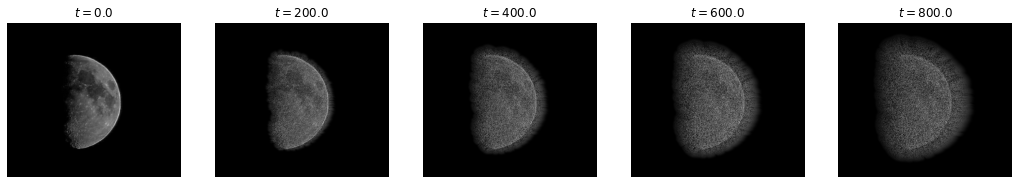

In [75]:
fig, axes = plt.subplots(1, 5, figsize=(18,4))
for i in range(len(axes)):
    axes[i].imshow(snapshots[i*4].get_field_on_grid(), vmin=0, cmap="gray")
    axes[i].axis('off')
    axes[i].set_title(f"$t={str(output_steps[4*i]*dt)}$")
    
plt.savefig("diffusion_example.png")